<a href="https://colab.research.google.com/github/BoldizsarZopcsak/DeepLearningNotebooks/blob/main/Notebooks/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNet Baseline Tutorial

Train EfficientNets from scratch. There are 8 different types of EfficientNets in tensorflow.keras.applications:
EfficientNetB0 - EfficientNetB7

They vary by their input shapes:

| Base model     	| Input Shape         |  
|----------------	|-------------------- |
| EfficientNetB0  | (None, 224, 224, 3) |   
| EfficientNetB1 	| (None, 240, 240, 3) |    
| EfficientNetB2 	| (None, 260, 260, 3) |    
| EfficientNetB3 	| (None, 300, 300, 3) |   
| EfficientNetB4 	| (None, 380, 380, 3) |   
| EfficientNetB5 	| (None, 456, 456, 3) |   
| EfficientNetB6 	| (None, 528, 528, 3) |   
| EfficientNetB7 	| (None, 600, 600, 3) |   

- [Paper](https://arxiv.org/pdf/1905.11946.pdf)
- [Keras blog, that this notebook is based on](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)
- [EfficientNetB0(...) attributes docs](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0)


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0


model = EfficientNetB0(weights='imagenet')
model.summary()

21839872/21834768 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
____________________

### Stanford Dogs Dataset

The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. There are 20,580 images, out of which 12,000 are used for training and 8580 for testing. Class labels are provided for all the 12,000 images.

Since the images have different sizes that are less than 200 pixels, we need to scale up all images to the EfficientNet size: 224

- [Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html)
- [Tensorflow Docs](https://www.tensorflow.org/datasets/catalog/stanford_dogs)

In [2]:
import tensorflow_datasets as tfds


# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
batch_size = 64


dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteUR4MNJ/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteUR4MNJ/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


### Visualizing

As a test, visualize the first 9 dogs in the dataset.

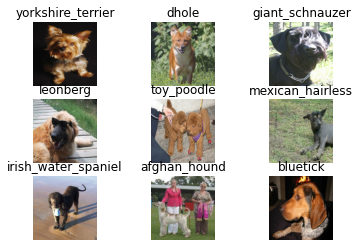

In [3]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

### Defining image augmentation

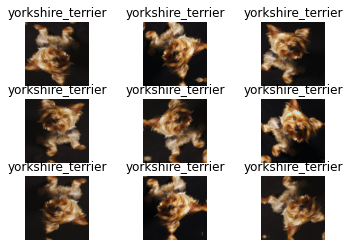

In [4]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential([
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1)
    ], name="img_augmentation")


# Testing img_augmentation with first dog
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

### Data pipeline

In [5]:
# One-hot / categorical encoding
# Add 1 in row of the vector representing that class (dog breed), otherwise 0
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

### Train the model from scratch

There are 12000 train images, so with a batch size of 64, that is 12000 / 64 = 187.5, so 187 batches per epoch.

In [6]:
from tensorflow.keras.applications import EfficientNetB0


# Define the model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])
model.summary()

epochs = 20
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
model.save("mymodel.h5")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 120)               4203291   
Total params: 4,203,291
Trainable params: 4,161,268
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/20
187/187 - 163s - loss: 4.9745 - accuracy: 0.0117 - val_loss: 5.0396 - val_accuracy: 0.0058
Epoch 2/20
187/187 - 121s - loss: 4.6501 - accuracy: 0.0219 - val_loss: 5.0800 - val_accuracy: 0.0209
Epoch 3/20
187/187 - 121s - loss: 4.4718 - accuracy: 0.0328 - val_loss: 4.9704 - val_accuracy: 0.0254
Epoch 4/20
187/187 - 120s - loss: 4.3407 - accuracy: 0.0441 - val_loss

### Plot Accuracy

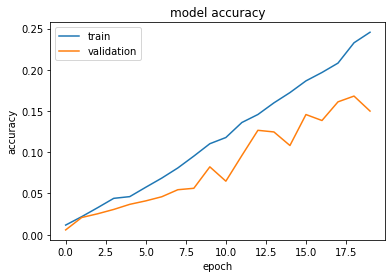

In [7]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [8]:
model.save("model.h5")

In [10]:
!ls
from google.colab import files
files.download('model.h5') 

model.h5  sample_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>